In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### データの読み込み

#<font color= "orange">1.インプットデータについて</font>

### **利用データ**


・S&P500 の 456 銘柄の日次終値  


### **特徴量算出にあたり使用するデータ**

・過去の１ヶ月（31日）リターンをランキング（10段階）



### **特徴量**
・３ヶ月、６ヶ月、１２ヶ月のリターン  
・各リターン÷ヒストリカルボラティリティ  
・MACD÷価格std÷ランクstd



### **学習と予測**
・月次終値データに変換  
・2016年2月 ~ 2021年1月の5年（60ヶ月）分を学習    
・2021年1月 ~ 2021年11月の12ヶ月分を予測  
・将来の１週間リターンをランキング（10段階）　・・・　予測対象

In [3]:
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
from IPython.display import display

import datetime
from datetime import datetime
import calendar
import numpy as np
import matplotlib.pyplot as plt

df_dl = pd.read_csv('/content/drive/MyDrive/仕事用/dataset.csv',header = 1).iloc[:,0:489]

df_dl = df_dl.dropna(axis = 1)

#終値のみを抽出
#Dateをdatetime化
#df = df_dl["Close"].reset_index()

start_date = '2015-01-01'
end_date = '2021-12-31'


df = df_dl
df["Date"] = df_dl["Symbols"]
df = df.drop("Symbols", axis = 1)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date"]).reset_index(drop = True)

#休場日の日付をパディング
#日付を全て網羅したリストを作成
list = pd.date_range(start = start_date, end = end_date, freq = "D")
date_df = pd.DataFrame({
    "Date":list
})

#date_dfとdfを結合
df = pd.merge(date_df, df, how = "left")
#欠陥値を補完 *最後の行に欠陥がある場合は注意
df = df.fillna(method = 'bfill')

#銘柄名を保存するリスト
symbols = df.drop('Date', axis = 1).columns

display(df)

,Date,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,...,WELL,WST,WDC,WU,WY,WHR,WMB,WYNN,XEL,XYL
0,2015-01-01,131.323,25.051,38.955,47.902,37.31,77.561,19.055,41.8382,72.34,...,54.7424,50.208,92.756,13.663,26.739,157.513,28.618,129.64,28.896,34.5610
1,2015-01-02,131.323,25.051,38.955,47.902,37.31,77.561,19.055,41.8382,72.34,...,54.7424,50.208,92.756,13.663,26.739,157.513,28.618,129.64,28.896,34.5610
2,2015-01-03,128.392,24.611,38.963,46.999,37.07,76.250,18.789,40.3878,71.98,...,55.4196,49.513,91.528,13.534,26.739,154.286,27.485,127.43,28.569,32.4109
3,2015-01-04,128.392,24.611,38.963,46.999,37.07,76.250,18.789,40.3878,71.98,...,55.4196,49.513,91.528,13.534,26.739,154.286,27.485,127.43,28.569,32.4109
4,2015-01-05,128.392,24.611,38.963,46.999,37.07,76.250,18.789,40.3878,71.98,...,55.4196,49.513,91.528,13.534,26.739,154.286,27.485,127.43,28.569,32.4109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2021-12-27,173.259,84.011,140.400,131.910,357.83,413.030,65.063,65.4195,577.68,...,82.8544,465.440,62.090,17.463,38.111,228.305,25.917,87.58,66.357,117.4680
2553,2021-12-28,174.180,84.845,139.420,131.890,357.44,412.970,66.276,66.2705,569.36,...,83.5346,464.430,62.840,17.552,38.304,228.414,25.818,86.46,67.151,118.6940
2554,2021-12-29,174.932,85.112,140.130,132.840,361.84,413.120,66.763,66.3502,569.29,...,83.9090,467.540,66.130,17.630,39.092,230.740,25.699,84.98,67.489,118.5340
2555,2021-12-30,174.180,84.597,139.940,133.400,362.06,411.530,67.091,66.2019,570.53,...,84.6876,470.890,65.370,17.788,39.371,230.245,25.581,86.15,67.757,118.2750


### 未来のリターンのランキングを作成

- 新しく df_t を作成。
- Rt個先のデータとの変化量を Rt_raw_return とする。

In [4]:
#Rt日前からのリターンを計算する関数
def make_raw_return(df, Rt):
  df_raw_return = (df.shift(Rt)/df) - 1
  df_raw_return.columns = df_raw_return.columns + '_' + str(Rt) + '_raw_return'
  return df_raw_return

#横向きにビンニングする関数
def make_rank_dataset(df, bin_list):
  df_rank = pd.DataFrame([])
  index = df.index
  df = df.T
  for i in index:
    df_rank['rank' + str(i)]  = pd.qcut(df[i], len(bin_list), labels=bin_list)
  df_rank = df_rank.T
  df_rank.index = index
  df_rank.columns = df_rank.columns + '_rank'
  return df_rank

#Rtを指定
#1週間先を想定して-7とする。
Rt = -7
df_test_raw_return = make_raw_return(df[symbols], Rt)

#nanを削除
df_test_raw_return = df_test_raw_return.dropna()

#10段階評価でビンを作成
bin_list = np.array(range(1,11,1))
df_t = make_rank_dataset(df_test_raw_return, bin_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


In [ ]:
display(df_test_raw_return)

In [ ]:
display(df_t)

### 特徴量を作成

In [7]:
#特徴量データセットを作成する関数
#入力：(時系列データセット,特徴量を生成するカラム）
#出力：特徴量データセット、特徴量名リスト
def make_features(df, columns):
  #特徴量用のデータセットを作成
  df_f = pd.DataFrame([])
  #特徴量名を格納するリストを作成
  df_f_list = []

  #株価
  df_f[columns+'_price'] = df[columns]
  df_f_list.append('_price')

  #ヒストリカルボラティリティの計算
  #(1)現在の終値を１日前の終値で割る
  df_f[columns + '_g_rate'] = df[columns]/df[columns].shift(1)
  #過去7日の標準偏差を計算し、単位期間換算する。
  df_f[columns + '_volatility'] = (df_f[columns + '_g_rate'].rolling(7).std())*(7**0.5)
  #(1)を削除
  df_f = df_f.drop(columns + '_g_rate', axis = 1)
  df_f_list.append('_volatility')


  #過去Rt日のrawリターン
  for Rt in [7, 14, 21, 28]:
    df_f[columns + '_past_' + str(Rt) + '_return'] = make_raw_return(df, Rt)
    #特徴量名を格納
    df_f_list.append('_past_' + str(Rt) + '_return')

  #過去Rt日のrawリターンのランク
  #過去Rt日のrawリターンのカラムを作っておく必要がある
  for Rt in [7, 14, 21, 28]:
    #10段階評価でビンを作成
    bin_list = np.array(range(1,11,1))
    #過去Rt日のrawリターンを使ってランク付
    df_f = df_f.dropna()
    df_f[columns + '_past_' + str(Rt) + '_return_rank'] = make_rank_dataset(df_f[columns + '_past_' + str(Rt) + '_return'] , bin_list)
    #特徴量名を格納
    df_f_list.append('_past_' + str(Rt) + '_return_rank')

  return df_f, df_f_list


df_f, df_f_list = make_features(df[symbols], df[symbols].columns)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


### 特徴リストの更新

In [8]:
print(df_f_list)

['_price', '_volatility', '_past_7_return', '_past_14_return', '_past_21_return', '_past_28_return', '_past_7_return_rank', '_past_14_return_rank', '_past_21_return_rank', '_past_28_return_rank']


In [9]:
df_f_list=[
 '_price',
 '_volatility', 
 '_past_7_return', 
 '_past_14_return', 
 '_past_21_return', 
 '_past_7_return_rank', 
 '_past_14_return_rank', 
 '_past_21_return_rank'
]

In [10]:
print(df_f_list)

['_price', '_volatility', '_past_7_return', '_past_14_return', '_past_21_return', '_past_7_return_rank', '_past_14_return_rank', '_past_21_return_rank']


### インプット用のデータフレームを作成

- 各週の金曜日のindexのみを抽出
- 学習期間とテストデータを指定

In [111]:
from datetime import datetime as dt

#学習データの開始期間と終了期間を指定
train_start_date = '2016-01-01'
train_end_date = '2020-12-31'
#テストデータの開始期間と終了期間を指定
test_start_date = '2021-01-01'
test_end_date = '2021-12-30'


#dfのindexのうち、金曜日のものだけを抽出し、indexをリストで保存
df_train_sample = df[ (df['Date'] >= train_start_date) & (df['Date'] <= train_end_date) ]
df_test_sample = df[ (df['Date'] >= test_start_date) & (df['Date'] <= test_end_date) ]
train_friday_index = df_train_sample[df_train_sample['Date'].dt.day_name() == 'Friday'].index
test_friday_index = df_test_sample[df_test_sample['Date'].dt.day_name() == 'Friday'].index


train_df_f = df_f.loc[train_friday_index]
train_df_t = df_t.loc[train_friday_index]

test_df_f = df_f.loc[test_friday_index]
test_df_t = df_t.loc[test_friday_index]


### データセットをインプット用に整形する関数を作成

In [112]:
#入力（特徴量データ、テストデータ）
def make_input(df_f, df_test_raw_return_rank):
  df_t_list = ['_-7_raw_return_rank']
  df_input_columns = df_f_list + df_t_list

  #インプットデータを保存するデータフレーム
  df_input = pd.DataFrame([],columns = df_input_columns )
  for symbol in symbols:
    #各銘柄について一時的に保存するデータフレーム
    df_0 = pd.DataFrame([])
    for feature in df_f_list:
      #各特徴量を格納、横方向に結合
      df_0 = pd.concat([df_0, df_f[symbol + feature]] ,axis = 1)
    for target in df_t_list:
      #ターゲットを追加、横方向に結合
      df_0 = pd.concat([df_0, df_test_raw_return_rank[symbol + target]], axis = 1)
    #特徴量とターゲットはインデックスがずれるので補正
    df_0 = df_0.dropna()
    #インプットデータに追加、縦方向に結合
    #結合前に列名を統一しないと新しい列が生成されてしまう
    df_0.columns = df_input.columns
    #インプットデータに縦結合
    df_input = pd.concat([df_input, df_0],  axis = 0)

  return df_input

### インプットデータを作成

In [113]:
train_input = make_input(train_df_f, train_df_t)
test_input = make_input(test_df_f, test_df_t)

#<font color= "orange">2.学習のアルゴリズムについて</font>

In [114]:
from itertools import combinations
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np   

### RankNetモデル

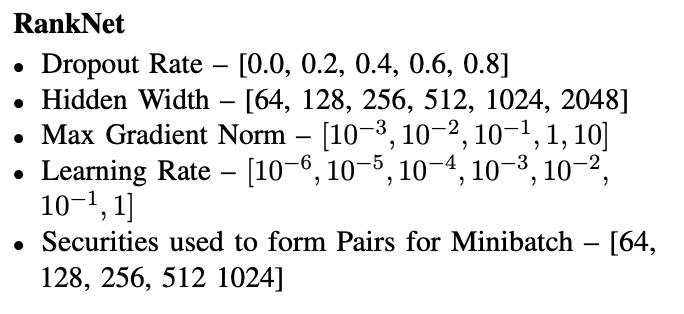

### 損失関数について

- 交差エントロピー損失

$P_{i,j}$：銘柄$i$が銘柄$j$より大きい確率。$s_i$が非常に大きい場合、$P_{i,j}$は１に近づく

$$ P_{i,j} = \frac{1}{1 + \exp(-\sigma(s_i - s_j))}$$

損失関数として、交差エントロピー損失$C$を用いる。  
$\bar{P_{i,j}}$：真の確率分布

$$C = -\bar{P_{i,j}} \log P_{i,j} - (1 - \bar{P_{i,j}}) \log (1 - P_{i,j})$$


ここで、$S_{i,j}$を次のように定義する
$$
S_{i,j} = 
\left\{
\begin{array}{ll}
1 & 銘柄i > 銘柄j \\
-1 & 銘柄j > 銘柄i \\
0 & それ以外
\end{array}
\right.
$$

このとき、真の確率$\bar{P_{i,j}}$は


$$ \bar{P_{i,j}} = \frac{1}{2} (1 + S_{i,j}) $$

と表せ、損失関数Cは次のようになる

$$C = \frac{1}{2} (1 + S_{i,j}) \sigma (s_i - s_j) + \log (1 + \exp(-\sigma(s_i - s_j)))$$

In [115]:
#RankNet
class Net(nn.Module):
    def __init__(self, D):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D, 136)
        self.ac1 = nn.Sigmoid()
        self.fc2 = nn.Linear(136, 272)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(272, 34)
        self.ac3 = nn.ReLU()
        self.fc4 = nn.Linear(34, 1)
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.fc1(x)
        #ReLU関数を使う場合は、sigmoid関数をはさんで0より大きくする必要がある
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        return x

#損失関数の定義：交差エントロピー消失
def pairwise_loss(s_i, s_j, S_ij, sigma=1):
    C = torch.log1p(torch.exp(-sigma * (s_i - s_j)))
    if S_ij == -1:
        C += sigma * (s_i - s_j)
    elif S_ij == 0:
        C += 0.5 * sigma * (s_i - s_j)
    elif S_ij == 1:
        pass
    else:
        raise ValueError("S_ij: -1/0/1")
    return C

#精度評価：真の順序と予測の順序が逆の数
def swapped_pairs(ys_pred, ys_target):
    N = ys_target.shape[0]
    swapped = 0
    for i in range(N - 1):
        for j in range(i + 1, N):
            if ys_target[i] < ys_target[j]:
                if ys_pred[i] > ys_pred[j]:
                    swapped += 1
            elif ys_target[i] > ys_target[j]:
                if ys_pred[i] < ys_pred[j]:
                    swapped += 1
    return swapped


#精度評価2:NDCG
def ndcg(y_true, y_pred, k=None, powered=False):
    def dcg(scores, k=None, powered=False):
        if k is None:
            k = scores.shape[0]
        if not powered:
            ret = scores[0]
            for i in range(1, k):
                ret += scores[i] / np.log2(i + 1)
            return ret
        else:
            ret = 0
            for i in range(k):
                ret += (2 ** scores[i] - 1) / np.log2(i + 2)
            return ret
    
    ideal_sorted_scores = np.sort(y_true)[::-1]
    ideal_dcg_score = dcg(ideal_sorted_scores, k=k, powered=powered)
    
    pred_sorted_ind = np.argsort(y_pred)[::-1]
    pred_sorted_scores = y_true[pred_sorted_ind]
    dcg_score = dcg(pred_sorted_scores, k=k, powered=powered)
    
    return dcg_score / ideal_dcg_score

def ndcg1(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=False)

def ndcg2(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=True)

### インプットデータをtensorに変換

In [ ]:
display(train_input)

In [117]:
#tensorに変換
X_train = torch.tensor(train_input[df_f_list].values.astype(np.float32))
X_valid = torch.tensor(test_input[df_f_list].values.astype(np.float32))
ys_train = torch.tensor(train_input['_-7_raw_return_rank'].values.astype(np.float32))
ys_valid = torch.tensor(test_input['_-7_raw_return_rank'].values.astype(np.float32))

In [118]:
#学習データの数
N_train = len(train_input)
#評価データの数
N_valid = len(test_input)
#特徴量の数
D = len(df_f_list)

In [119]:
def train(X_train, ys_train):
  idx = torch.randperm(N_train)

  X_train = X_train[idx]
  ys_train = ys_train[idx]

  cur_batch = 0
  for it in range(N_train // batch_size):
      batch_X = X_train[cur_batch: cur_batch + batch_size]
      batch_ys = ys_train[cur_batch: cur_batch + batch_size]
      cur_batch += batch_size

      opt.zero_grad()
      batch_loss = torch.zeros(1)
      if len(batch_X) > 0:
          #batch_pred = net(batch_X)
          batch_pred = net(batch_X.float())

          # sampling pairs from batch
          for _ in range(n_sampling_combs):
              i, j = np.random.choice(range(batch_size), 2)
              s_i = batch_pred[i]
              s_j = batch_pred[j]
              if batch_ys[i] > batch_ys[j]:
                  S_ij = 1
              elif batch_ys[i] == batch_ys[j]:
                  S_ij = 0
              else:
                  S_ij = -1
              loss = pairwise_loss(s_i, s_j, S_ij)
              batch_loss += loss
              #print(loss)

      batch_loss.backward(retain_graph=True)
      opt.step()

In [120]:
def valid(X_valid, ys_valid):
  with torch.no_grad():
    valid_pred = net(X_valid.float())
    valid_swapped_pairs = swapped_pairs(valid_pred, ys_valid)
    print(f"epoch: {epoch + 1} valid swapped pairs: {valid_swapped_pairs}/{N_valid * (N_valid - 1) // 2}")

In [137]:
epochs = 10
batch_size = 1024
n_sampling_combs = 50

net = Net(D)
opt = optim.Adam(net.parameters())
for epoch in range(epochs): 
  print(epoch) 
  train(X_train, ys_train)
  #if epoch % 5 == 0:
    #valid(X_valid, ys_valid)

0
1
2
3
4
5
6
7
8
9


#<font color= "orange">3. アウトプット</font>

### リターンの計算方法

$$ 
r_{\tau_{m}, \tau_{m+1} } = \frac{1}{n_{\tau_{m}}} \sum_{i=1}^{n_{\tau_{m}}} X_{\tau_{m}}^{(i)} \frac{\sigma_{tgt}}{\sigma_{\tau_{m}^{(i)}}} r_{\tau_{m},\tau_{m+1}}^{(i)}
$$

- $r_{\tau_{m}, \tau_{m+1} }$：時刻$\tau_{m}$から時刻$\tau_{m+1}$の間で得られるリターン
- $X_{\tau_{m}}^{(i)}$：{-1, 0, 1}、時刻$\tau_{m}$のポートフォリオ調整で、資産$i$を{売るか、何もしないか、買うか}
- $\sigma_{tgt}$：ターゲットボラティリティ15%で固定
- $\sigma_{\tau_{m}}^{(i)}$：資産$i$の期間内（論文では１ヶ月）のボラティリティ
- $r_{\tau_{m},\tau_{m+1}}^{(i)}$：資産$i$のリターン

In [138]:
pred_ndarray = net(X_valid.float()).detach().cpu().numpy()
X_valid_ndarray = X_valid.detach().cpu().numpy()

In [139]:
result = pd.concat([pd.DataFrame(X_valid_ndarray, columns = df_f_list), pd.DataFrame(pred_ndarray, columns = ['_-7_raw_return_rank'])], axis = 1)

In [140]:
result = pd.DataFrame(pred_ndarray.reshape(52, len(symbols)), columns = symbols)

In [141]:
#10段階評価でビンを作成
bin_list = np.array(range(1,11,1))
result_rank = make_rank_dataset(result, bin_list)

In [142]:
result_rank_X = result_rank.applymap(lambda x: 1 if x == 10 else (-1 if x == 1 else 0))
result_raw_return = df_test_raw_return.loc[test_friday_index]

In [143]:
return_sum = []
for i in range(len(result_rank_X)):
  return_sum.append((result_rank_X.iloc[i].reset_index(drop = True) * result_raw_return.iloc[i].reset_index(drop = True)).sum())

In [144]:
return_sum = []
for i in range(len(result_rank_X)):
  return_sum.append((result_rank_X.iloc[i].reset_index(drop = True) * result_raw_return.iloc[i].reset_index(drop = True)).sum())

In [ ]:
plt.plot(np.cumsum(return_sum))
#plt.plot(return_sum)

In [146]:
result_all_rank = pd.DataFrame([])
for i in range(11):
  result_rank_X = result_rank.applymap(lambda x: 1 if x == i else (0 if x <= 1 else 0))
  result_raw_return = df_test_raw_return.loc[test_friday_index]
  result_volatility = df_f[symbols + '_volatility'].loc[test_friday_index]
  return_sum = []
  for j in range(len(result_rank_X)):
    return_sum.append((result_rank_X.iloc[j].reset_index(drop = True) * result_raw_return.iloc[j].reset_index(drop = True)/result_volatility.iloc[j].reset_index(drop = True)).sum())
  result_all_rank[str(i)] = np.cumsum(return_sum)

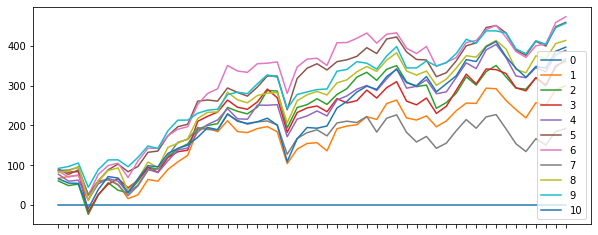

In [152]:
fig, ax = plt.subplots(figsize = (10,4))
#for i in range(1, 11):
  #ax.plot(result_all_rank.index, result_all_rank[str(i)])
ax.plot(result_all_rank)
ax.set_xticks(result_all_rank.index)
ax.tick_params(labelbottom=False)
ax.legend(result_all_rank.columns)
plt.show()

#<font color= "orange">4. 精度評価</font>

アウトプットデータの要素の大小関係が、正解ラベルデータの要素の大小関係と、どのくらいずれているのかをカウント

```
def swapped_pairs(ys_pred, ys_target):
    N = ys_target.shape[0]
    swapped = 0
    for i in range(N - 1):
        for j in range(i + 1, N):
            if ys_target[i] < ys_target[j]:
                if ys_pred[i] > ys_pred[j]:
                    swapped += 1
            elif ys_target[i] > ys_target[j]:
                if ys_pred[i] < ys_pred[j]:
                    swapped += 1
```